In [1]:
from nnsight import NNsight
import torch 
from transformers import GPTJForCausalLM, AutoTokenizer 
from IPython.display import clear_output
from nnsight import LanguageModel
from typing import List, Callable
import torch
import numpy as np
from IPython.display import clear_output
import seaborn as sns
import matplotlib.pyplot as plt
from lmm_synthetic.mm_train.gptj_vlm import GPTJ_VLM


model_path = "/home/sjoshi/lmm/lmm_synthetic/mm_train/checkpoints/sft_v3_spatial_grid_multimodal/checkpoint-2235"
model = GPTJ_VLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model.config.pretrained_lm_path)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(DEVICE)
model.eval()

/home/sjoshi/anaconda3/envs/vlm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-17 14:25:50.489 | INFO     | lmm_synthetic.mm_train.utils:load_vision_encoder:26 - Loading vision encoder: clip
2024-12-17 14:25:50.493 | INFO     | lmm_synthetic.mm_train.utils:load_vision_encoder:29 - Using CLIP model as the vision encoder
/home/sjoshi/anaconda3/envs/vlm/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2024-12-17 14:25:51.268 | INFO     | lmm_synthetic.mm_train.utils:load_multimodal_projector:89 - Loading multimodal projector: linear


GPTJ_VLM(
  (gptj): GPTJForCausalLM(
    (transformer): GPTJModel(
      (wte): Embedding(50257, 768)
      (drop): Dropout(p=0.0, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPTJBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPTJAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=False)
          )
          (mlp): GPTJMLP(
            (fc_in): Linear(in_features=768, out_features=3072, bias=True)
            (fc_out): Linear(in_features=3072, out_features=768, bias=True)
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.0, inpla

In [2]:
from lmm_synthetic.mm_train.utils import load_vision_encoder 
_, image_transforms, _  = load_vision_encoder(model.config.vision_encoder_config)

2024-12-17 14:26:09.114 | INFO     | lmm_synthetic.mm_train.utils:load_vision_encoder:26 - Loading vision encoder: clip
2024-12-17 14:26:09.116 | INFO     | lmm_synthetic.mm_train.utils:load_vision_encoder:29 - Using CLIP model as the vision encoder


In [8]:
model.gptj.transformer.h.register_forward_hook(test)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

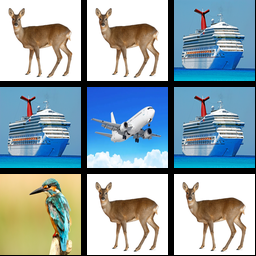

In [10]:
image_path = '/home/sjoshi/lmm/lmm_synthetic/data/generated/v3_spatial_grid_multimodal/images/train_368.png'

from PIL import Image 

image = Image.open(image_path)
display(image)

In [11]:
prompts = [("""The grid above is size 3 by 3. Each cell contains an object from ['airplane', 'deer', 'bird', 'ship'].
What object is in row {row}, column {column}? """, 
"""| deer | deer | ship |
| ship | airplane | ship |
| bird | deer | deer |
The grid above is size 3 by 3. Each cell contains an object from ['airplane', 'deer', 'bird', 'ship'].
What object is in row {row}, column {column}? """)]

In [62]:
# Remove all hooks recursively
def remove_all_hooks(model):
    for module in model.modules():
        module._forward_hooks.clear()
        module._backward_hooks.clear()
        module._forward_pre_hooks.clear()

# Apply to your model
remove_all_hooks(model)

intermediate_outputs = {}

def parse_output(output):
    return torch.nn.functional.softmax(model.gptj.lm_head(model.gptj.transformer.ln_f(output)), dim=-1)[0]

for i, layer in enumerate(model.gptj.transformer.h):
    print("Attaching hooks to layer", str(i).zfill(2))  # Print with leading zeros

    # Hook for Attention
    def attn_hook(module, input, output, layer_idx=i):
        formatted_idx = f"{layer_idx:02d}"  # Format as 2 digits
        output = output[0]
        intermediate_outputs[f"layer_{formatted_idx}_attn"] = output[:, -1, :]

    layer.attn.register_forward_hook(attn_hook)

    # Hook for MLP
    def mlp_hook(module, input, output, layer_idx=i):
        formatted_idx = f"{layer_idx:02d}"  # Format as 2 digits
        intermediate_outputs[f"layer_{formatted_idx}_mlp"] = output[-1, :]
        
    if i == len(model.gptj.transformer.h) - 1:
        formatted_idx = f"{i:02d}"  # Format as 2 digits
        def last_block_hook(module, input, output):
            intermediate_outputs[f"final_output"] = output[0][:, -1, :]
        layer.register_forward_hook(last_block_hook)

    layer.mlp.register_forward_hook(mlp_hook)


Attaching hooks to layer 00
Attaching hooks to layer 01
Attaching hooks to layer 02
Attaching hooks to layer 03
Attaching hooks to layer 04
Attaching hooks to layer 05
Attaching hooks to layer 06
Attaching hooks to layer 07
Attaching hooks to layer 08
Attaching hooks to layer 09
Attaching hooks to layer 10
Attaching hooks to layer 11


In [63]:
def hook_fn(module, input, output):
    def recursively_print_type(obj, indent=0):
        if isinstance(obj, (list, tuple)):
            print(' ' * indent + f'{type(obj)} of length {len(obj)}')
            for item in obj:
                recursively_print_type(item, indent + 2)
        elif isinstance(obj, dict):
            print(' ' * indent + f'{type(obj)} with {len(obj)} keys')
            for key, value in obj.items():
                print(' ' * (indent + 2) + f'Key: {key}')
                recursively_print_type(value, indent + 4)
        elif isinstance(obj, torch.Tensor):
            print(' ' * indent + f'{type(obj)} with shape {obj.shape}')
        else:
            print(' ' * indent + f'{type(obj)}')

    recursively_print_type(output)


In [64]:
tokenizer.pad_token_id = tokenizer.eos_token_id

In [ ]:
def generate(vlm, row=0, col=0):
    VLM = vlm
    ROW = row
    COL = col
    MAX_NEW_TOKENS = 3
    intermediate_outputs = {}
    with torch.no_grad():
        output = None
        if VLM:
            images = image_transforms(image).unsqueeze(0).to(DEVICE)
            inputs = tokenizer(
                [prompts[0][0].format(row=ROW, column=COL)],
                return_tensors="pt",
                padding=True,
            ).to(device)
            
            output = model.generate(
                images=images,
                text_input_ids= inputs.input_ids,
                max_new_tokens=MAX_NEW_TOKENS,
                use_cache=False
            )
        else:
            inputs = tokenizer(
                [prompts[0][1].format(row=ROW, column=COL)],
                return_tensors="pt",
                padding=True,
            ).to(device)
            output = model.generate(
                images=None,
                text_input_ids=inputs.input_ids,
                max_new_tokens=MAX_NEW_TOKENS,
                use_cache=False
            )
            output = output[:, inputs.input_ids.shape[-1]:]
        print(output[0])
        print(f"|{tokenizer.decode(output[0], skip_special_tokens=True)}|")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([ 32,  25, 320], device='cuda:0')
|A: airplane|


In [ ]:
def generate()

In [66]:
for key in sorted(intermediate_outputs.keys()):
    intermediate_outputs[key] = parse_output(intermediate_outputs[key])
    print(key, intermediate_outputs[key].shape)

final_output torch.Size([50257])
layer_00_attn torch.Size([50257])
layer_00_mlp torch.Size([50257])
layer_01_attn torch.Size([50257])
layer_01_mlp torch.Size([50257])
layer_02_attn torch.Size([50257])
layer_02_mlp torch.Size([50257])
layer_03_attn torch.Size([50257])
layer_03_mlp torch.Size([50257])
layer_04_attn torch.Size([50257])
layer_04_mlp torch.Size([50257])
layer_05_attn torch.Size([50257])
layer_05_mlp torch.Size([50257])
layer_06_attn torch.Size([50257])
layer_06_mlp torch.Size([50257])
layer_07_attn torch.Size([50257])
layer_07_mlp torch.Size([50257])
layer_08_attn torch.Size([50257])
layer_08_mlp torch.Size([50257])
layer_09_attn torch.Size([50257])
layer_09_mlp torch.Size([50257])
layer_10_attn torch.Size([50257])
layer_10_mlp torch.Size([50257])
layer_11_attn torch.Size([50257])
layer_11_mlp torch.Size([50257])


In [67]:
def get_token_ids(words: List[str], tokenizer: AutoTokenizer) -> List[int]:
    token_ids = []
    for word in words:
        token_id = tokenizer.encode(word, add_special_tokens=False)
        token_ids.extend(token_id)
    return token_ids

# Example usage
vocab = [
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck"
    ]

In [68]:
def probs_over_answers(intermediate_outputs, tokens, include_other_tokens=True):
    token_ids = {token: tokenizer.encode(f" {token}", add_special_tokens=False)[0] for token in tokens}
    
    # Extract probabilities for the specified token IDs from intermediate_outputs
    token_probs_list = []
    for key in sorted(intermediate_outputs.keys()):
        if key != "final_output":
            probs = intermediate_outputs[key]
            token_probs = probs[[token_ids[token] for token in tokens]]
            if include_other_tokens:
                other_token_probs = probs.sum() - token_probs.sum()
                token_probs_list.append(torch.cat((token_probs, other_token_probs.unsqueeze(0))).detach().cpu().numpy())
            else:
                token_probs_list.append(token_probs.detach().cpu().numpy())
    
    # Add final_output at the end
    final_probs = intermediate_outputs["final_output"]
    final_token_probs = final_probs[[token_ids[token] for token in tokens]]
    if include_other_tokens:
        final_other_token_probs = final_probs.sum() - final_token_probs.sum()
        token_probs_list.append(torch.cat((final_token_probs, final_other_token_probs.unsqueeze(0))).detach().cpu().numpy())
    else:
        token_probs_list.append(final_token_probs.detach().cpu().numpy())
    
    token_probs_np = np.array(token_probs_list)
    
    # Create a mask for the maximum values in each row, excluding the last column (other_tokens) if included
    max_mask = (token_probs_np[:, :-1] == token_probs_np[:, :-1].max(axis=1, keepdims=True)) if include_other_tokens else (token_probs_np == token_probs_np.max(axis=1, keepdims=True))
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    yticklabels = [f'Layer {i//2} {"attn" if i % 2 == 0 else "mlp"}' for i in range(token_probs_np.shape[0] - 1)]
    yticklabels.append('final_output')
    xticklabels = tokens + ['other_tokens'] if include_other_tokens else tokens
    ax = sns.heatmap(token_probs_np, 
                     xticklabels=xticklabels, 
                     yticklabels=yticklabels, 
                     cmap='viridis', 
                     annot=True,
                     fmt=".2f",
                     linewidths=0.5,
                     linecolor='black')
    
    # Add red outline around the maximum values in each row, excluding the last column (other_tokens) if included
    for y in range(token_probs_np.shape[0]):
        for x in range(token_probs_np.shape[1] - (1 if include_other_tokens else 0)):  # Exclude the last column if included
            if max_mask[y, x]:
                ax.add_patch(plt.Rectangle((x, y), 1, 1, fill=False, edgecolor='red', lw=3))
    
    plt.xlabel('Tokens')
    plt.ylabel('Layers')
    plt.title('Average Probabilities over Layers for Each Token')
    plt.show()

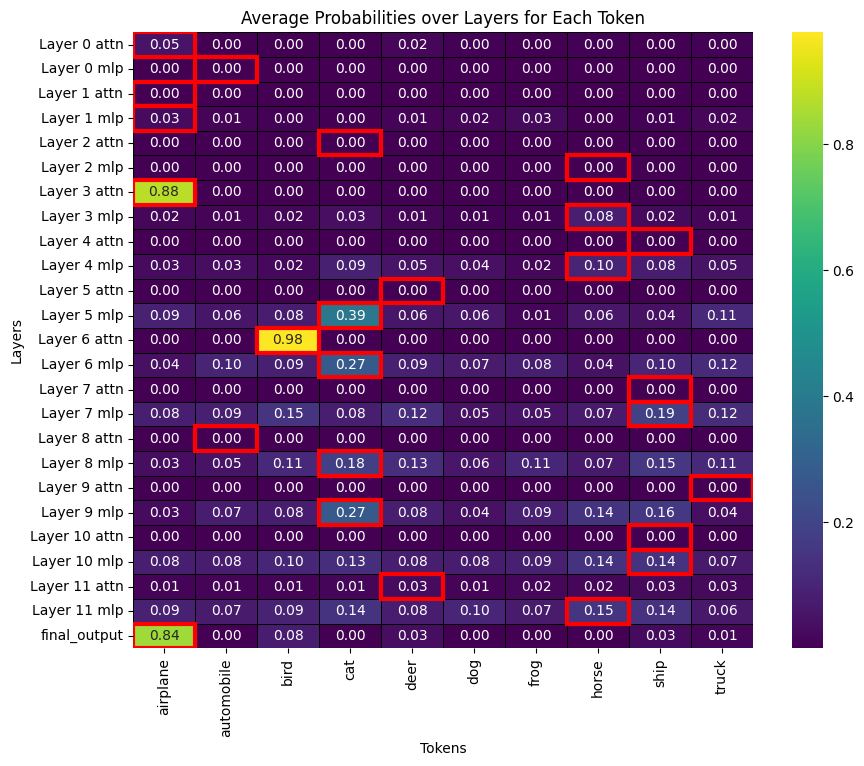

In [69]:
probs_over_answers(intermediate_outputs, vocab, include_other_tokens=False)